# Project MA8404


# The vanishing gradient problem 

A residual neural network is a convolutional neural network designed to avoid the "vanishing gradient" problem. This problem occurs when the gradients of the loss function become extremely small as they backpropagate through the layers during the training process. When the gradients are too small, it becomes difficult for the network to update its weights efficiently, resulting in slow learning. The opposite problem, exploding gradients, can also occur and lead to unstable training.

The vanishing gradient problem often arises when using the hyperbolic tangent as the activation function, which is the one I am using in this project. When you stack multiple layers in a deep neural network, and each layer applies the activation function, the gradients can diminish exponentially as they propagate backward through the layers. This makes it challenging to update the weights of the earlier layers effectively. A solution to this problem is making use of residual neural networks.



# Residual Neural Networks 

Residual Neural Networks (ResNets) avoid the vanishing gradient problem through the use of skip connections, or residual connections, which allow gradients to flow more easily through the network. In a standard feedforward neural network, each layer takes the output of the previous layer as its input. However, in a ResNet, each layer takes the output of the previous layer and adds it to its own output. The skip connection adds the original input 
$H(x)$ to the transformed output $F(x)$, creating a residual mapping.

$$y = F(x) + H(x)$$

# Neural Ordinary Differential Equations

Neural ODEs are a different approach to designing neural networks. Instead of specifying a fixed number of discrete layers, Neural ODEs define the dynamics of the network continuously using ordinary differential equations. The continuous-time transformation is learned by the network, and the forward pass can be seen as solving an initial value problem. Neural ODEs can capture continuous-time behavior and have the potential to model complex, long-term dependencies in data. The connection between ResNets and Neural ODEs lies in the fact that Neural ODEs can be used to model the transformation within each layer of a ResNet. In other words, you can view a ResNet as a discrete approximation of a Neural ODE. By doing this, you can capture the continuous-time modeling capabilities of Neural ODEs while still benefiting from the skip connections that ResNets introduce to address the vanishing gradient problem. Thus, Neural ODEs can provide a continuous-time interpretation or extension of ResNets. Neural ODEs are particularly well-suited for modeling continuous-time processes and capturing long-term dependencies in data. They have the potential to be more expressive for tasks where the underlying dynamics are continuous and complex. Neural ODEs may provide more interpretable insights into the underlying continuous dynamics of the data, making them valuable for certain scientific and domain-specific applications.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import time 
import random

# The data 



The MNIST dataset consists of images of handwritten digits, and each image is associated with a label, the digit it represents.

We first need to preprocess the data before putting it into the machine learning model. We begin by resizing the images to smaller 8×8 pixels. This is done to reduce the computational cost of training the model. We also ensure that all our data points have the same size, as our model expects a specific input shape.

Next, we convert the images to PyTorch Tensor objects, which is the standard format for deep learning models. The final step involves creating a dataloader, which groups the training data into batches and shuffles the data.

Grouping the data is essential because training a deep learning model on the entire dataset at once is usually computationally expensive. Instead, we process a more manageable amount of data at one time. Splitting the data into batches also takes advantage of parallelism, resulting in a shorter training time.

By shuffling the data, we avoid overfitting to the training data. This is especially important if the data has a fixed order, for example, if it is ordered by class. Such ordering might cause the model to perform well on certain classes but poorly on others. Introducing randomness to the training process can also help the model converge faster.

In [2]:
# Resizing and converting to tensor object
transform = transforms.Compose([transforms.Resize(8), transforms.ToTensor()])

#Loading the training MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#Grouping into batch sizes of 64 + shuffle the data
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)


We now want to look at the data in order to see how a sample might look like.

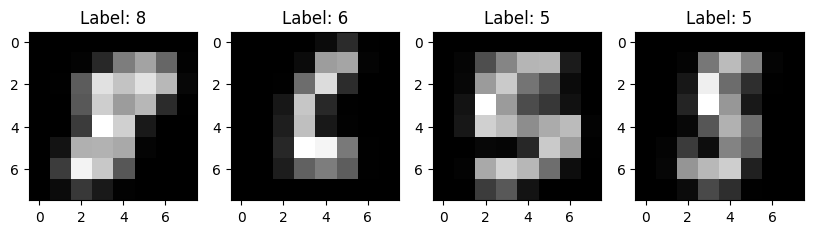

In [3]:
data, labels = next(iter(dataloader))

# Plot the data samples
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for i in range(4):
    axs[i].imshow(data[i].squeeze(), cmap='gray')
    axs[i].set_title(f"Label: {labels[i]}")

plt.show()

# The model

Our model will consist of two main components, the Neural ODE and the Classifier. 

# The Neural ODE

This component takes the input data (images) and processes it using a continuous-time Neural ODE. The Neural ODE function (NeuralODEFunc) applies transformations to the input data over time, and the Neural ODE layer (NeuralODE) integrates these transformations to produce an output. The continuous-time behavior allows the model to capture complex dynamics in the data.

In this implementation, we have the following Neural ODE

$$\frac{dy}{dt} = \sigma(Wy +b)$$

Where $\sigma(z) = \tanh(z)$.

The $\sigma(z)$ represents the dynamics of the system, where $W$ is the weights and $b$ the biases of a neural network. 

The Neural ODE involves learning the function $\sigma(z)$ using a neural network, and during training, the neural network's parameters $W$ and $b$ are adjusted to fit the observed data and approximate the true dynamics of the system.

The $\sigma(z)$ function is called the "Activation Function". This is what makes the neural network be able to learn complex patterns. Without activation functions, the neural network would behave like a linear model, making it limited in its capacity to represent these complex patterns.

# Why $\sigma(z) = \tanh(z)$?

The hyperbolic tangent ($\tan h$) activation function can be a good choice for classification tasks, including those on the MNIST dataset, for several reasons.

$\tan h$ is zero-centered. This means that the mean of the output is close to zero when the inputs are centered around zero. This can be advantageous for optimization during training because it helps prevent issues like vanishing gradients, which can occur when using other activation functions, such as ReLU. Zero-centered activations tend to make optimization easier and faster.

$\tan h$ is a smooth, continuous function, which makes it differentiable everywhere. The smoothness of tanh allows for more stable and predictable gradients during training.

$\tan h$ is a non-linear activation function, which is essential for enabling neural networks to learn complex, non-linear relationships in data.

In [4]:
# Define the Neural ODE function
class NeuralODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODEFunc, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, t, y):
        dydt = torch.tanh(self.fc(y))
        return dydt


The code defines a Python class named NeuralODEFunc that inherits from nn.Module. In PyTorch, nn.Module is the base class for all neural network modules. This class will encapsulate the neural network operations.

In [5]:
# Define the Neural ODE model

class NeuralODE(nn.Module):
    def __init__(self, func, timesteps, method):
        super(NeuralODE, self).__init__()
        self.func = func
        self.timesteps = timesteps
        self.method = method

    def forward(self, y0):
        t = torch.linspace(0, 1, self.timesteps)
        y = odeint(self.func, y0, t, method=self.method)
        return y[-1]

The ODEint function solves the ODE using a specified method. This could be any of the following methods

{"dopri8", "dopri5", "bosh3", "fehlberg2", "adaptive_heun", "euler", "midpoint", "rk4", "explicit_adams", "implicit_adams", "fixed_adams", "scipy_solver"}

The method returns the final state of the system, which is the state at the last time point. This represents the solution of the ODE at the end of the specified time interval.

# The Classifier

 This code defines a basic classifier neural network with a single linear layer. It takes input features and produces class scores as the output. 

In [6]:
class Classifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [7]:
# Create the model
methods = ["dopri8", "dopri5", "bosh3", "fehlberg2", "adaptive_heun", 
           "euler", "midpoint", "rk4", "explicit_adams", "implicit_adams", "fixed_adams", "scipy_solver"]


input_dim = 64
hidden_dim = 64
num_classes = 10

ode_func = NeuralODEFunc(input_dim, hidden_dim)
model = nn.Sequential(NeuralODE(ode_func, timesteps=10, method = "euler"), Classifier(hidden_dim, num_classes))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [8]:
def CreateAndTrain(epochs=25,timestep=10,method = "euler"):

    input_dim = 64
    hidden_dim = 64
    num_classes = 10

    ode_func = NeuralODEFunc(input_dim, hidden_dim)
    model = nn.Sequential(NeuralODE(ode_func, timesteps=timestep, method=method), Classifier(hidden_dim, num_classes))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # Training loop
    for epoch in range(epochs):
        for data, labels in dataloader:
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            outputs = model(data)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

In [9]:
import torch.optim as optim


def CreateAndTrain(epochs=25, timestep=10, method="euler"):
    input_dim = 64
    hidden_dim = 64
    num_classes = 10

    ode_func = NeuralODEFunc(input_dim, hidden_dim)
    model = nn.Sequential(NeuralODE(ode_func, timesteps=timestep, method=method), Classifier(hidden_dim, num_classes))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the training loss
    training_loss = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, labels in dataloader:
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            outputs = model(data)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss.append(epoch_loss / len(dataloader))

    return model, training_loss



In [10]:
start_time = time.time()
euler_model, euler_loss = CreateAndTrain(epochs=25,timestep=10,method = "euler")
end_time = time.time()
euler_time = end_time - start_time

"""
start_time = time.time()
explicit_adams_model, explicit_adams_loss = CreateAndTrain(epochs=25,timestep=10,method = "explicit_adams")
end_time = time.time()
explicit_adams_time = end_time - start_time
"""
start_time = time.time()
rk4_model, rk4_loss = CreateAndTrain(epochs=25,timestep=10,method = "rk4")
end_time = time.time()
rk4_time = end_time - start_time

start_time = time.time()
dopri5_model, dopri5_loss = CreateAndTrain(epochs=25,timestep=10,method = "dopri5")
end_time = time.time()
dopri5_time = end_time - start_time


In [11]:
print("Training time of different methods")
print("Forward Euler: " + str(euler_time/60) + " minutes")
#print("Explicit Adams: " + str(explicit_adams_time/60)+ " minutes")
print("RK4 : " + str(rk4_time/60)+ " minutes")
print("Dopri5 : " + str(dopri5_time/60)+ " minutes")

Training time of different methods
Forward Euler: 1.4474597851435342 minutes
RK4 : 2.5116148312886555 minutes
Dopri5 : 18.34163083632787 minutes


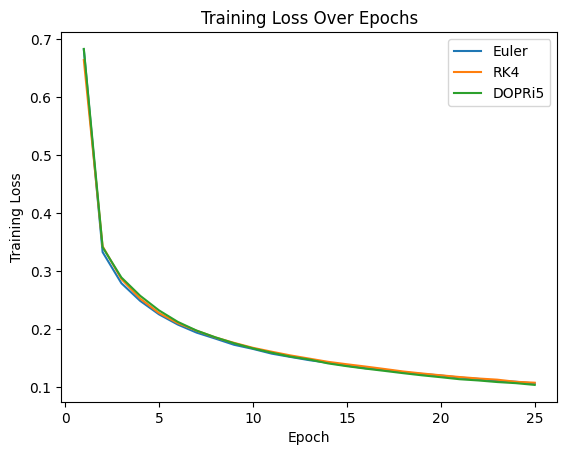

In [12]:
plt.plot(range(1, len(euler_loss) + 1), euler_loss, label = "Euler")
#plt.plot(range(1, len(explicit_adams_loss) + 1), explicit_adams_loss, label = "ExAdams")
plt.plot(range(1, len(rk4_loss) + 1), rk4_loss, label = "RK4")
plt.plot(range(1, len(dopri5_loss) + 1), dopri5_loss, label = "DOPRi5")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()

In [13]:
def CalculateTrainingAccuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.view(data.size(0), -1)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# After training your model with CreateAndTrain function
# You can calculate the training accuracy like this
euler_training_accuracy = CalculateTrainingAccuracy(euler_model, dataloader)
#ex_adam_training_accuracy = CalculateTrainingAccuracy(explicit_adams_model, dataloader)
RK4_training_accuracy = CalculateTrainingAccuracy(rk4_model, dataloader)
dopri5_training_accuracy = CalculateTrainingAccuracy(dopri5_model, dataloader)

print(f"Euler Method Training Accuracy: {euler_training_accuracy:.2f}%")
#print(f"Explicit Adams Training Accuracy: {ex_adam_training_accuracy:.2f}%")
print(f"RK4 Method Training Accuracy: {RK4_training_accuracy:.2f}%")
print(f"DOPRI5 Training Accuracy: {dopri5_training_accuracy:.2f}%")

Euler Method Training Accuracy: 96.74%
RK4 Method Training Accuracy: 96.95%
DOPRI5 Training Accuracy: 96.62%


We observe that Dopri5 has a significantly longer training time than the other methods. 

In [14]:
def save_model(model):

    # Save the model
    torch.save(model.state_dict(), 'mnist_model.pth')

    # Load the model
    model.load_state_dict(torch.load('mnist_model.pth'))


# The testing

In [15]:
transform = transforms.Compose([transforms.Resize(8), transforms.ToTensor()])

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)


In [16]:
def predict(model):
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data, labels in test_dataloader:
            data = data.view(data.size(0), -1)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return accuracy

In [17]:
euler_accuracy = predict(euler_model)
#midpoint_accuracy = predict(explicit_adams_model)
rk4_accuracy = predict(rk4_model)
dopri5_accuracy = predict(dopri5_model)

print(f"Euler method accuracy on the test set: {euler_accuracy:.2f}%")
#print(f"Midpoint method accuracy on the test set: {midpoint_accuracy:.2f}%")
print(f"RK4 method accuracy on the test set: {rk4_accuracy:.2f}%")
print(f"Dopri5 method accuracy on the test set: {dopri5_accuracy:.2f}%")

Euler method accuracy on the test set: 96.42%
RK4 method accuracy on the test set: 96.52%
Dopri5 method accuracy on the test set: 96.22%


Even though Dopri5 has an especially long training time, it does not seem as it leads to especially better accuracy than the other methods. 

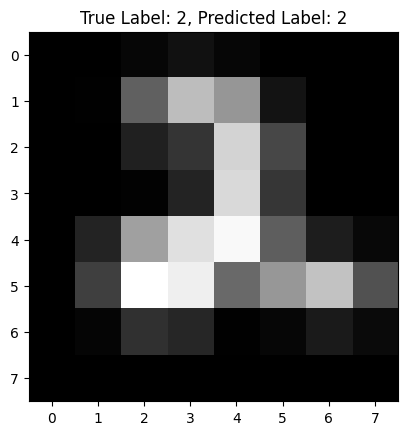

In [18]:
model = rk4_model
model.eval()

# Select a random sample from the test dataset

sample_idx = random.randint(0, len(test_dataloader.dataset) - 1)
sample_data, sample_label = test_dataloader.dataset[sample_idx]

with torch.no_grad():
    sample_data = sample_data.view(1, -1)  # Reshape the data for a single sample
    output = model(sample_data)
    predicted_label = torch.argmax(output)

# Convert the data tensor to a NumPy array
sample_data = sample_data.view(8, 8).numpy()  # Reshape the data to its original shape

# Convert the labels to Python integers (not necessary for 'sample_label')
sample_label = int(sample_label)
predicted_label = int(predicted_label)

# Plot the image and the predicted label
plt.figure()
plt.imshow(sample_data, cmap='gray')
plt.title(f"True Label: {sample_label}, Predicted Label: {predicted_label}")
plt.show()


# Conclusions

Higher order Runge-Kutta methods resulted in significantly longer time but not a notable improvement in accuracy. However our data was rather simple and there remains to analyze results for more complex data. In the future it would be interesting to analyze performance on time dependent data. 